# Notebook for analysis of integrated pseudobulk and single cell GRN

## Imports

In [1]:
#Import libraries
import os
import glob
import pickle
import pandas as pd
import numpy as np
from pyscenic.aucell import aucell
import seaborn as sns
import scanpy
import scanpy.api as sc
from matplotlib import pyplot as plt
from sklearn import preprocessing
import matplotlib

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synon

In [2]:
#Set figure parameters
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
scanpy.api.set_figure_params(scanpy=True, dpi=80, dpi_save=1200, frameon=True, vector_friendly=True)

# Preprocess scanpy objects

In [3]:
#loading module for importing and preprossing pseudobulk gene expression data
from RegulonPreprocessing import preprocess_pb

In [4]:
droplet, facs, mca = preprocess_pb('data')

Loading datasets
Subsetting genes (expressed in 10% of cells in all datasets)
Normalizing
Log transforming
Detecting highly variable genes
Regressing out: # counts and % mito
Scaling
Removing unannotated cells
Annotating datasets


In [5]:
#Read colormap
colormap = pd.read_csv('data/ColorMap.csv', sep=';')

In [6]:
mapper = {x:y for x,y in zip(colormap.celltype, colormap.Super_type)}

In [7]:
droplet.obs['Super'] = droplet.obs.celltype.map(mapper)
facs.obs['Super'] = facs.obs.celltype.map(mapper)
mca.obs['Super'] = mca.obs.celltype.map(mapper)


# Regulon space

In [8]:
#Loading regulon analysis module
from RegulonAnalysis import RegulonsAnalysis

In [9]:
#Settings
DATA_FOLDER="/work/sduknn/Andreas/TM_MCA/database_SCENIC/tmp/droplet"
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons_10_percent.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs_10_percent.csv")

#Reload regulons and motifs
with open(REGULONS_FNAME, "rb") as f:
    regulons_drop = pickle.load(f)

#make expression matrix*
ex_matrix = droplet.X
ex_matrix = pd.DataFrame(data= ex_matrix,
                              index=droplet.obs.index.tolist(),
                              columns=droplet.var.index.values)
        
#calculate regulon AUC
droplet_auc_mtx = aucell(ex_matrix, regulons_drop, num_workers=6)

#initialize regulon object
droplet1 = RegulonsAnalysis( regulons_drop,  droplet, droplet_auc_mtx)


In [10]:
#Settings
DATA_FOLDER="/work/sduknn/Andreas/TM_MCA/database_SCENIC/tmp/facs"
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons_10_percent.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs_10_percent.csv")

#Reload regulons and motifs
with open(REGULONS_FNAME, "rb") as f:
    regulons_facs = pickle.load(f)

#make expression matrix
ex_matrix = facs.X
ex_matrix = pd.DataFrame(data= ex_matrix,
                              index=facs.obs.index.tolist(),
                              columns=facs.var.index.tolist())
        
#calculate regulon AUC
facs_auc_mtx = aucell(ex_matrix, regulons_facs, num_workers=6)

#initialize regul'on object
facs1 = RegulonsAnalysis( regulons_facs,  facs, facs_auc_mtx)

In [11]:
#Settings
DATA_FOLDER="/work/sduknn/Andreas/TM_MCA/database_SCENIC/tmp/mca"
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons_10_percent.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs_10_percent.csv")

#Reload regulons and motifs
with open(REGULONS_FNAME, "rb") as f:
    regulons_mca = pickle.load(f)

#make expression matrix
ex_matrix = mca.X
ex_matrix = pd.DataFrame(data= ex_matrix,
                              index=mca.obs.index.tolist(),
                              columns=droplet.var.index.tolist())
        
#calculate regulon AUC
mca_auc_mtx = aucell(ex_matrix, regulons_mca, num_workers=6)

#initialize regulon object
mca1 = RegulonsAnalysis( regulons_mca,  mca, mca_auc_mtx)

In [12]:
droplet

AnnData object with n_obs × n_vars = 1061 × 11245 
    obs: 'celltype', 'n_counts', 'percent_mito', 'protocol', 'tissue', 'S_score', 'G2M_score', 'phase', 'Super'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [13]:
facs

AnnData object with n_obs × n_vars = 703 × 11245 
    obs: 'celltype', 'n_counts', 'percent_mito', 'protocol', 'tissue', 'S_score', 'G2M_score', 'phase', 'Super'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [14]:
mca

AnnData object with n_obs × n_vars = 2776 × 11245 
    obs: 'celltype', 'n_counts', 'percent_mito', 'protocol', 'tissue', 'S_score', 'G2M_score', 'phase', 'Super'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [16]:
#Merging scanpy gene expression objects
merged = sc.AnnData.concatenate(droplet, facs ,mca,  join='inner')
merged.obs['celltype'] = pd.Categorical(merged.obs['celltype'])
merged.obs['protocol'] = pd.Categorical(merged.obs['protocol'])

In [17]:
merged_auc_mtx = pd.concat([droplet_auc_mtx, facs_auc_mtx, mca_auc_mtx], join='inner', axis=0)
merged_auc_mtx.shape

(4540, 174)

In [18]:
pseudo = RegulonsAnalysis(regulons_drop, merged, merged_auc_mtx)


/gpfs/gss1/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/Final_notebooks/5_Regulon_analysis/RegulonAnalysis.py:471: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if 'X_pca' in  self.regulon_scanpy.obsm:


PCA not computed - using 5 principal components


... storing 'tissue' as categorical
... storing 'phase' as categorical
... storing 'Super' as categorical


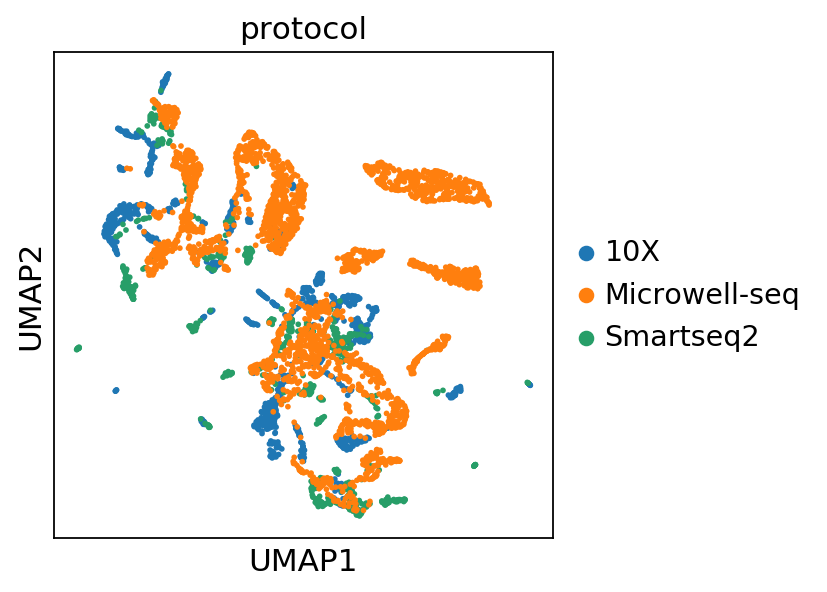

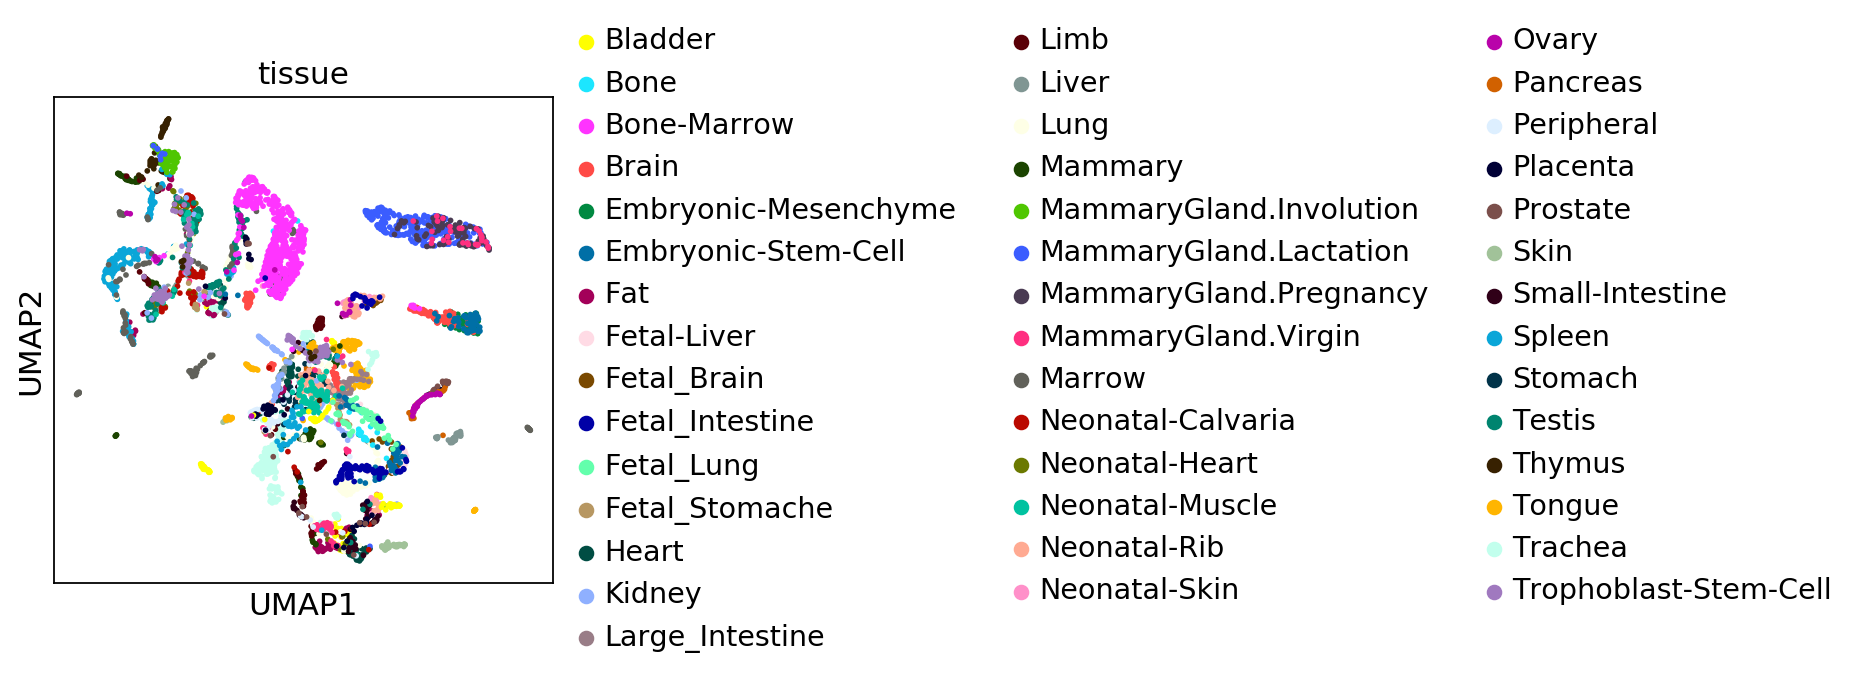

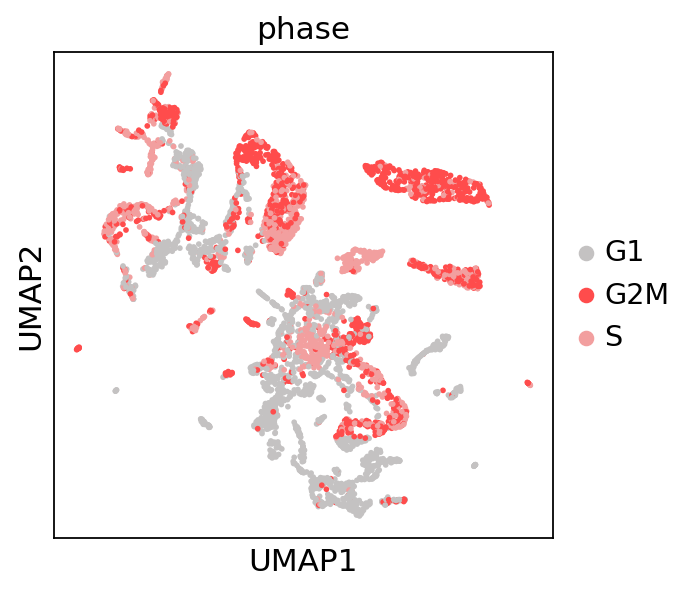

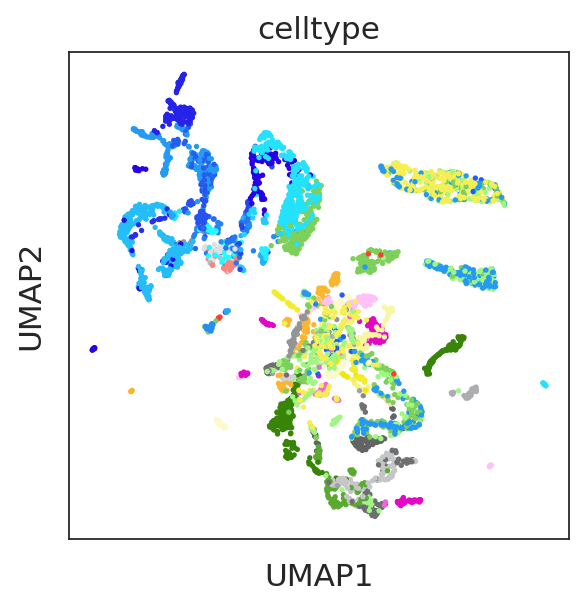

In [19]:
pseudo.plot('umap', 'protocol', color_index=colormap, pcs= 5, color_index_type='color_grad')
pseudo.plot('umap', 'tissue', color_index=colormap, pcs= 5, color_index_type='color_grad')
pseudo.plot('umap', 'cellcycle', color_index=colormap, pcs= 5, color_index_type='color_grad')
pseudo.plot('umap', 'celltype', color_index=colormap, pcs= 5, color_index_type='color_grad', point_size=2)


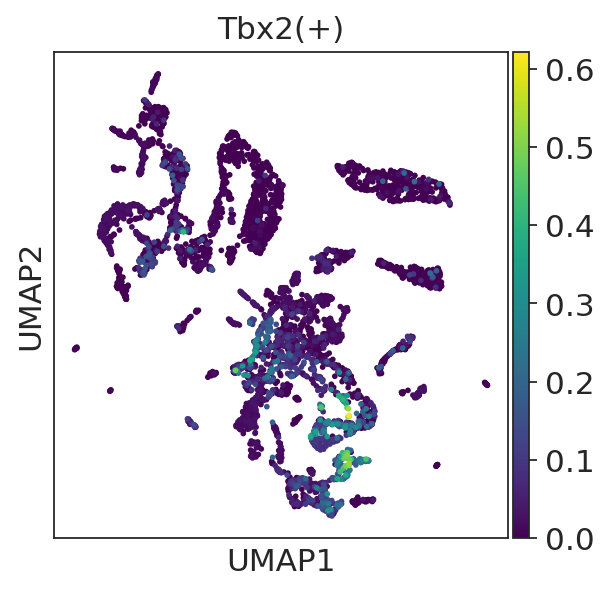

In [20]:
pseudo.plot('umap', 'Tbx2(+)', color_index=colormap, pcs= 5)

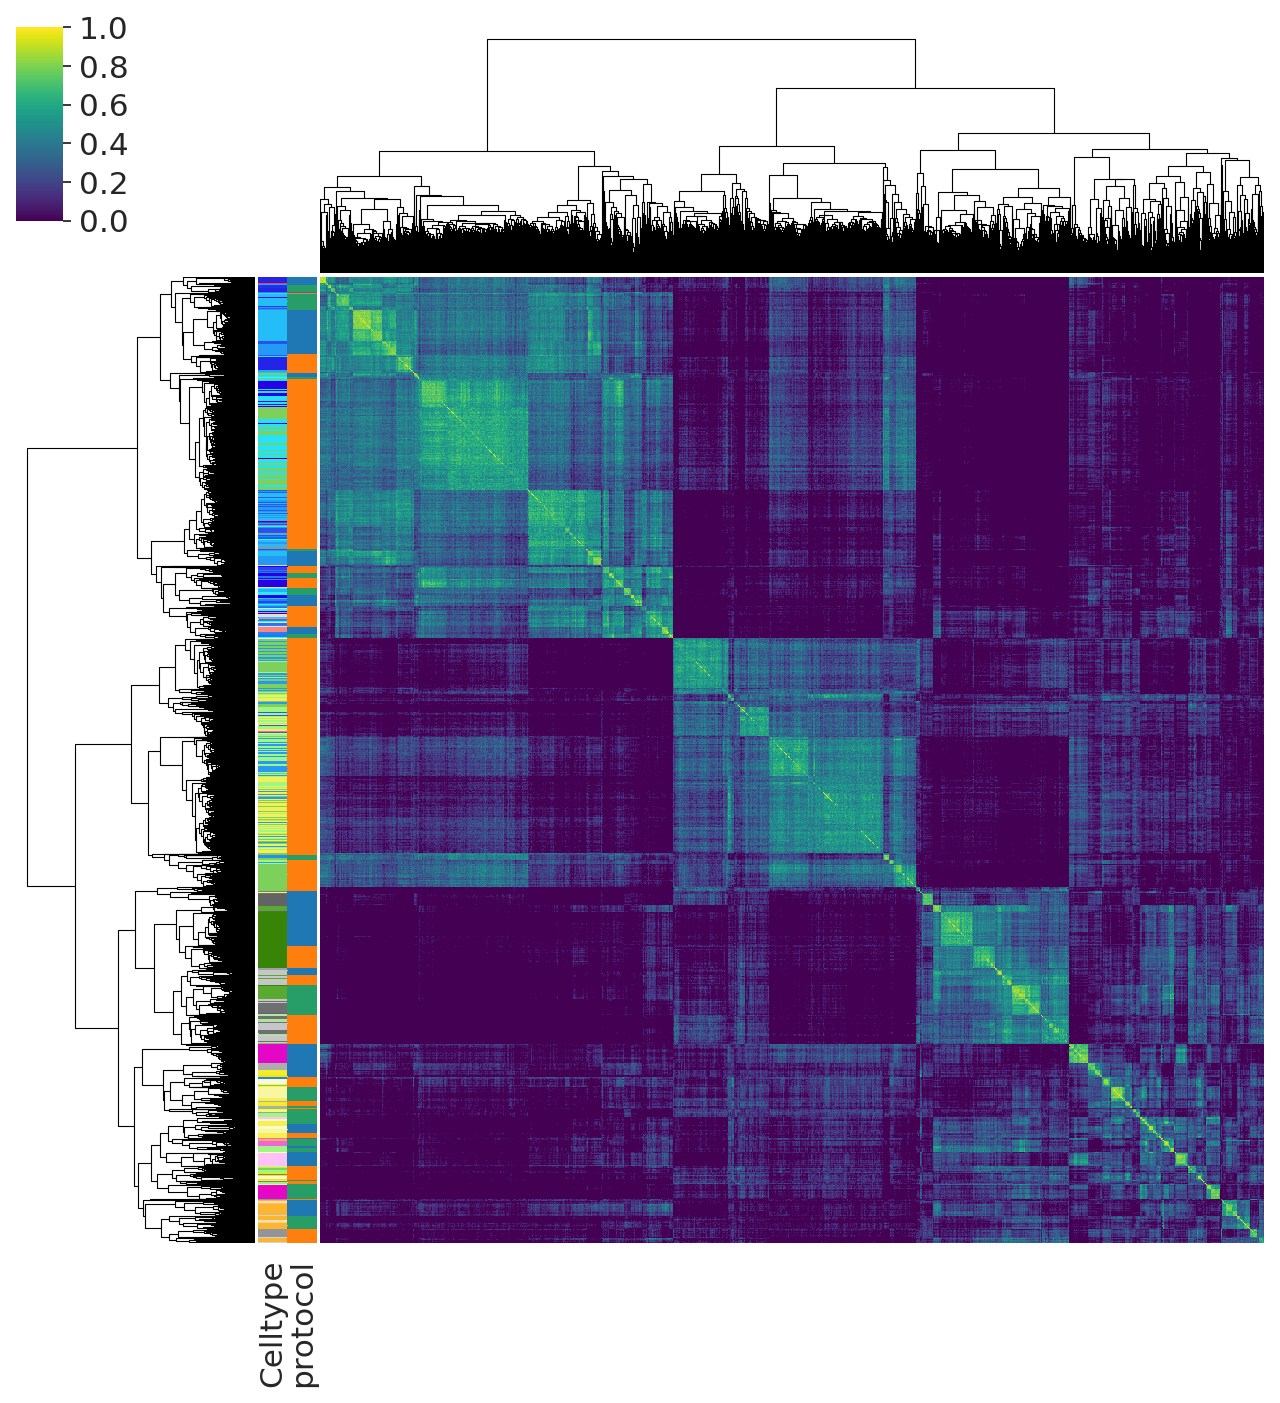

In [21]:
pseudo.cell_regulon_cor(color_index = colormap, 
                        color_by='color_grad')


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


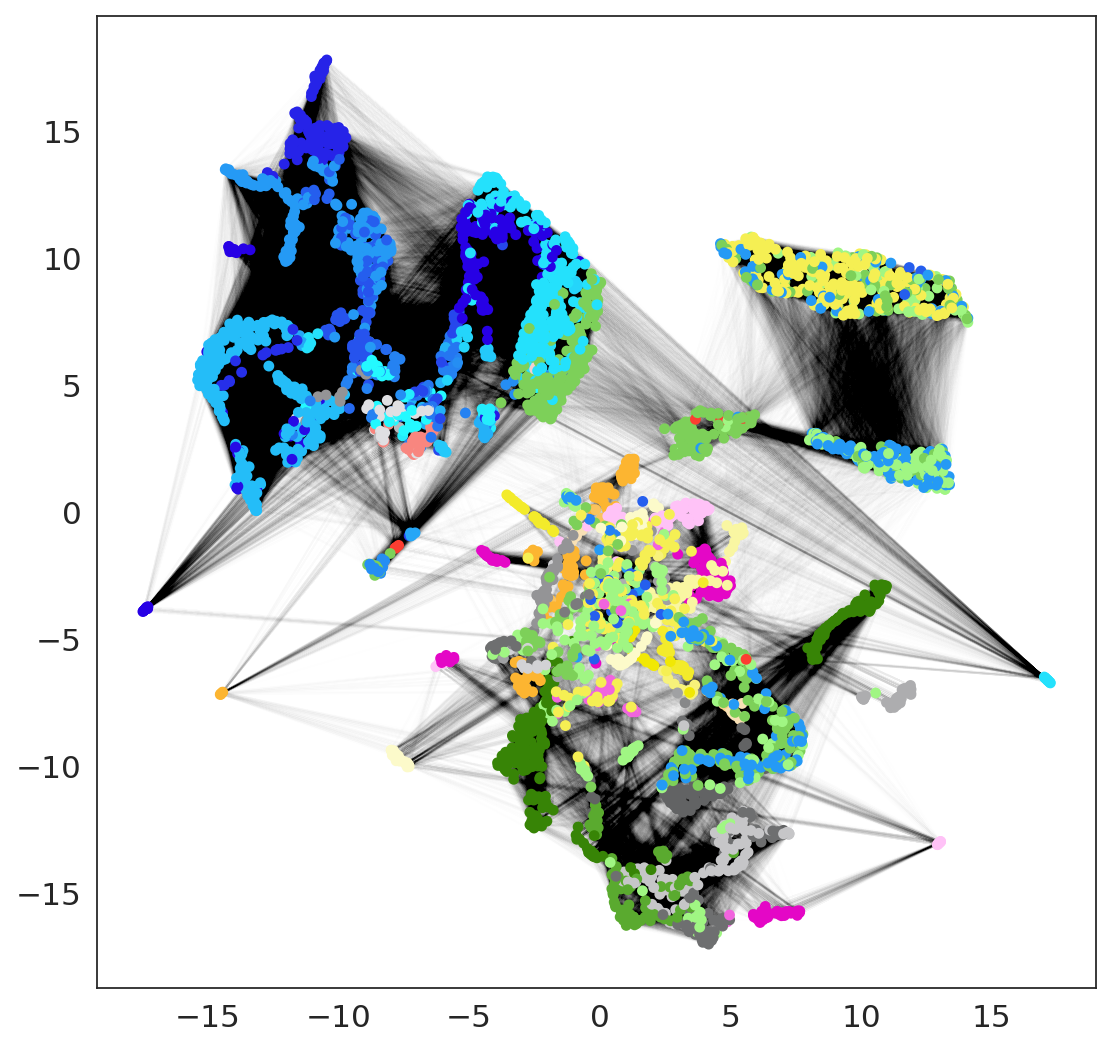

In [22]:
pseudo.cell_regulon_network(0.50, color_index = colormap, dr='umap', pcs=5, color_by = 'color_grad', save = 'data/pseudobulk_tsne_all.gexf')



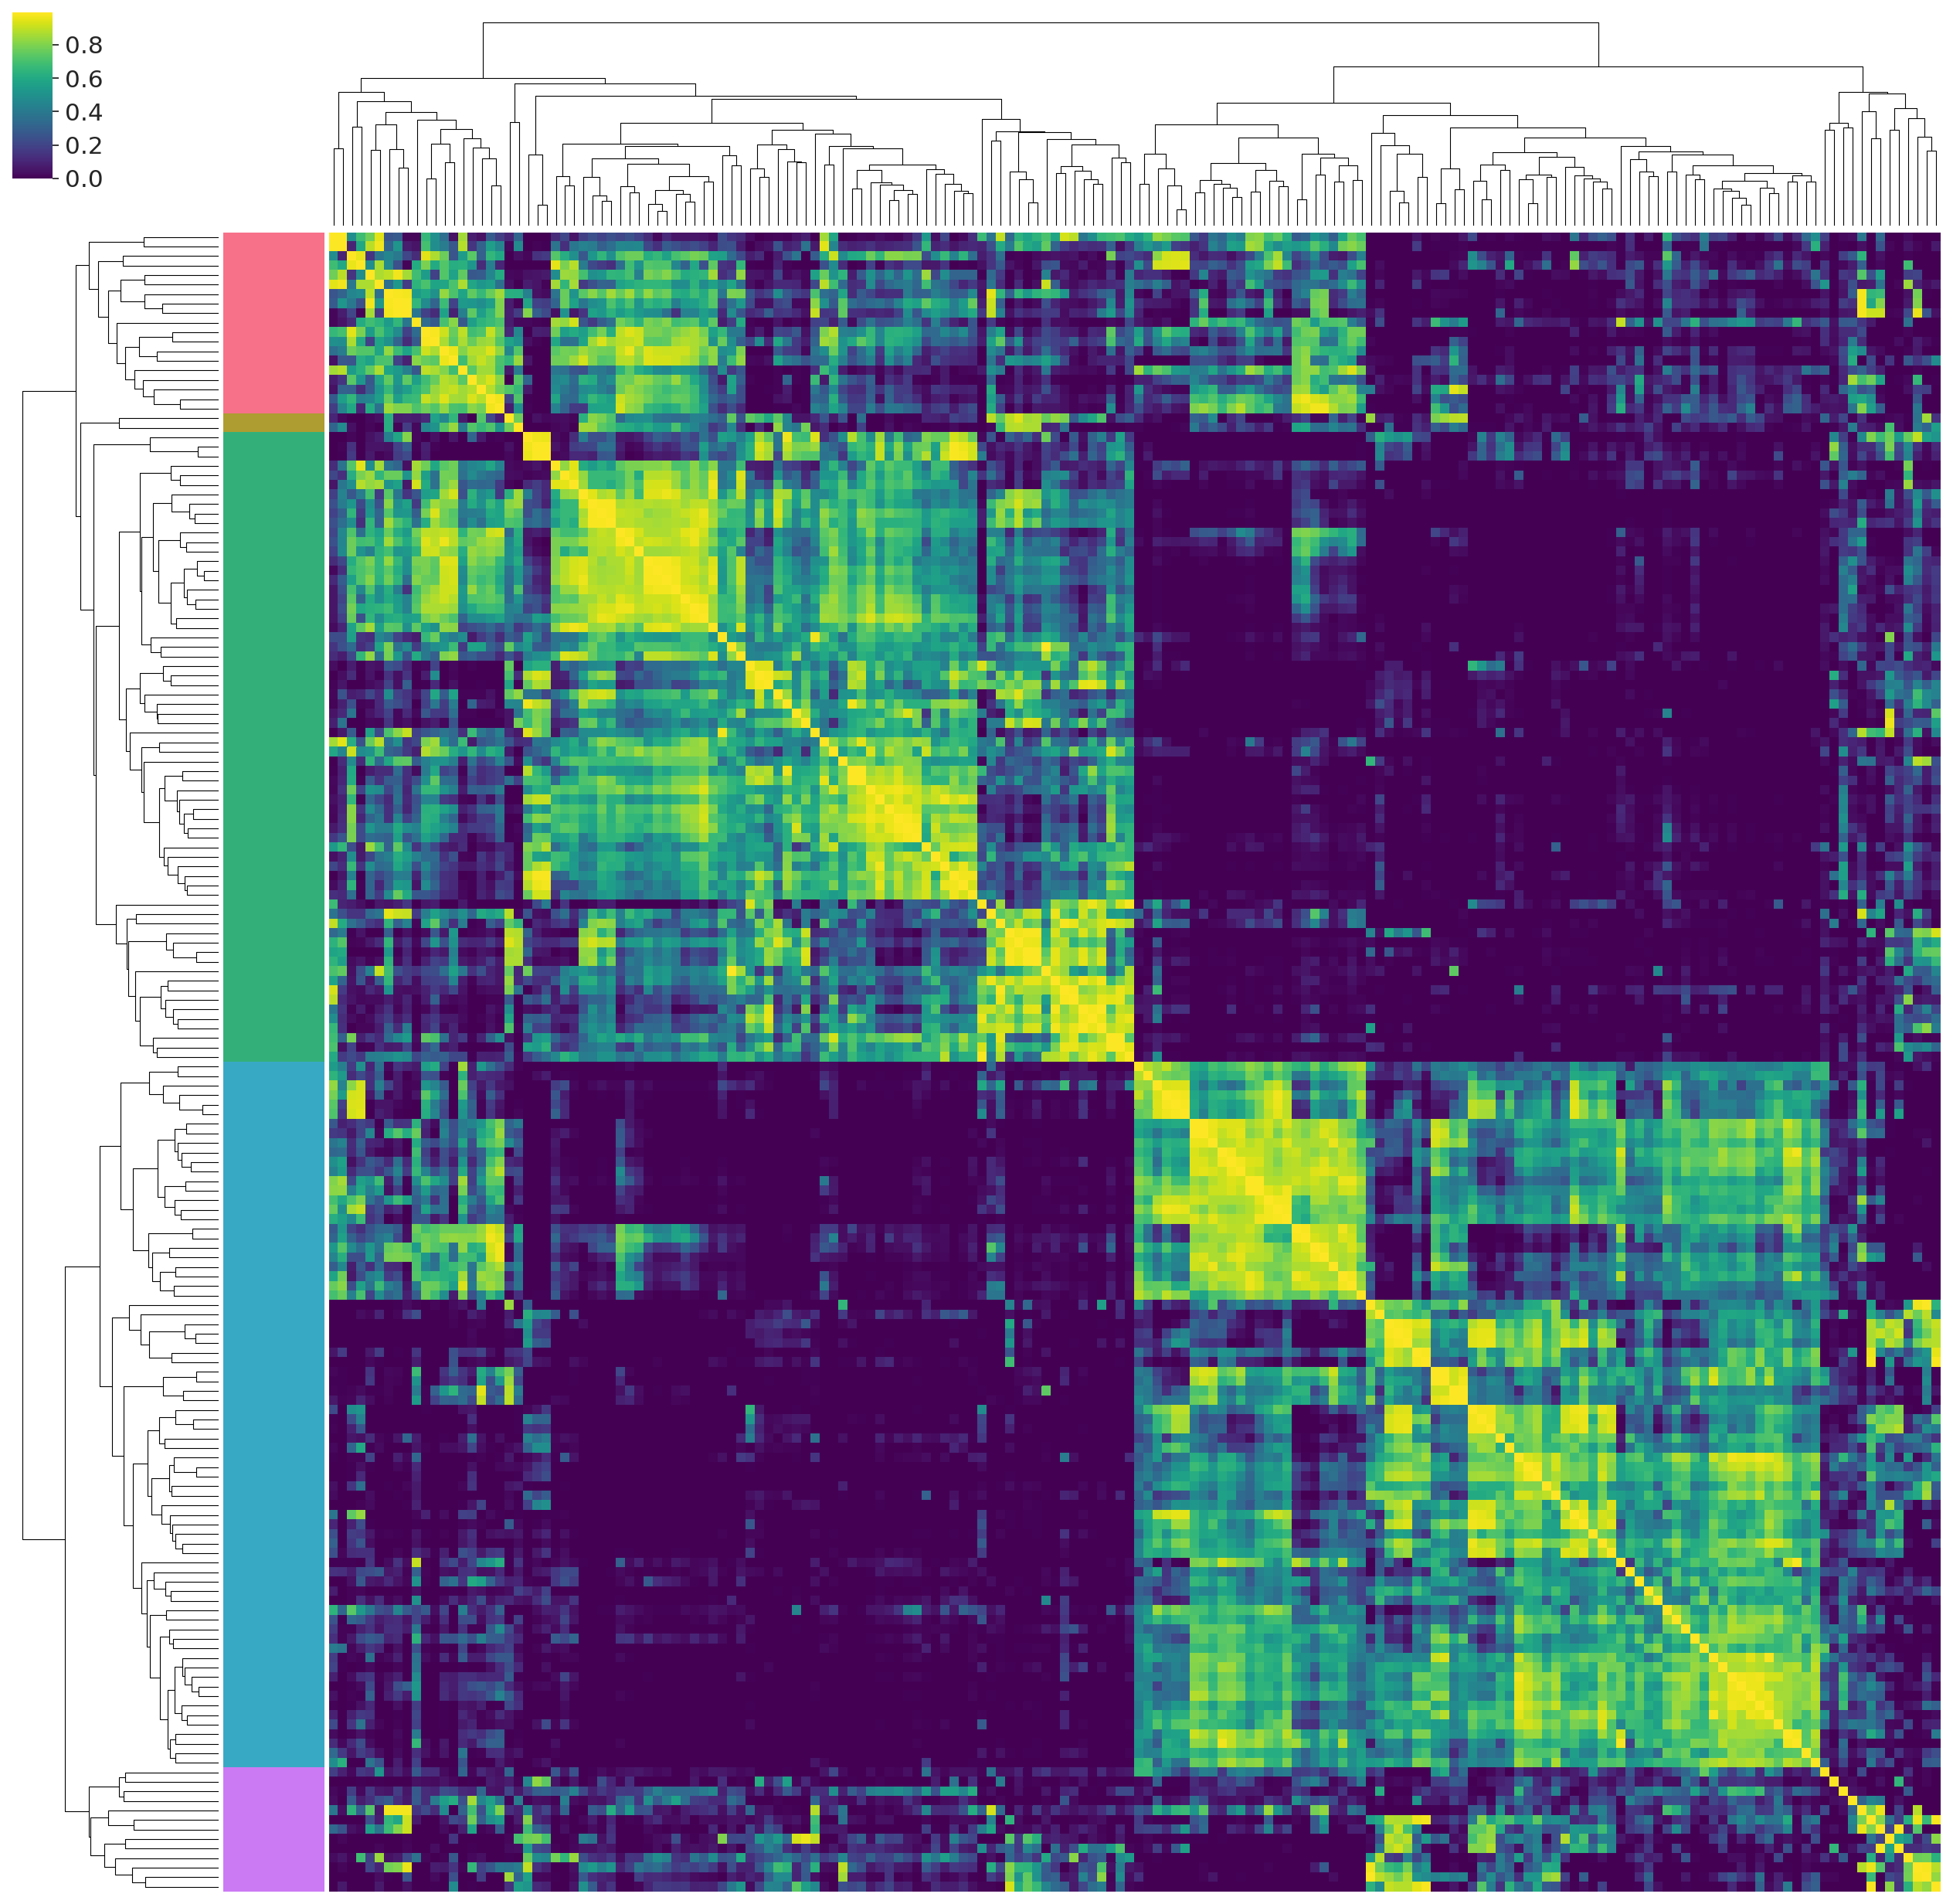

In [23]:
pseudo.plot_csi(cluster_n=5)

In [24]:
pseudo.csi_mat_df.to_csv('data/integrated_CSI.tsv', sep = '\t')

In [25]:
label = pseudo.clustering

In [26]:
reg_clust_lut = pseudo.lut
reg_clust_lut[0] = (.8, .8, .8)

In [27]:
reg_clust_lut

{1: (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 2: (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 3: (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 4: (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 5: (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 0: (0.8, 0.8, 0.8)}

In [108]:
def general_csi_col(obj):
    new_clustering = []
    for idx, i in enumerate(obj.regulon_scanpy.var_names):
        a = 0
        for xdx, x in enumerate(pseudo.regulon_scanpy.var_names):
            if i == x:
                a = pseudo.clustering[xdx]
            if xdx == len(pseudo.regulon_scanpy.var_names) -1 :
                new_clustering.append(a)
    return new_clustering

In [109]:
drop_clust = general_csi_col(droplet1)
facs_clust = general_csi_col(facs1)
mca_clust = general_csi_col(mca1)

In [25]:
import pickle
def save(file, obj):
    with open(file, 'wb') as f:
        pickle.dump(obj, f)
save('data/drop_clust', drop_clust)
save('data/facs_clust', facs_clust)
save('data/mca_clust', mca_clust)

The clustering can be transferred to single datasets using the colormap and clustering in the "plot_csi" method like this:

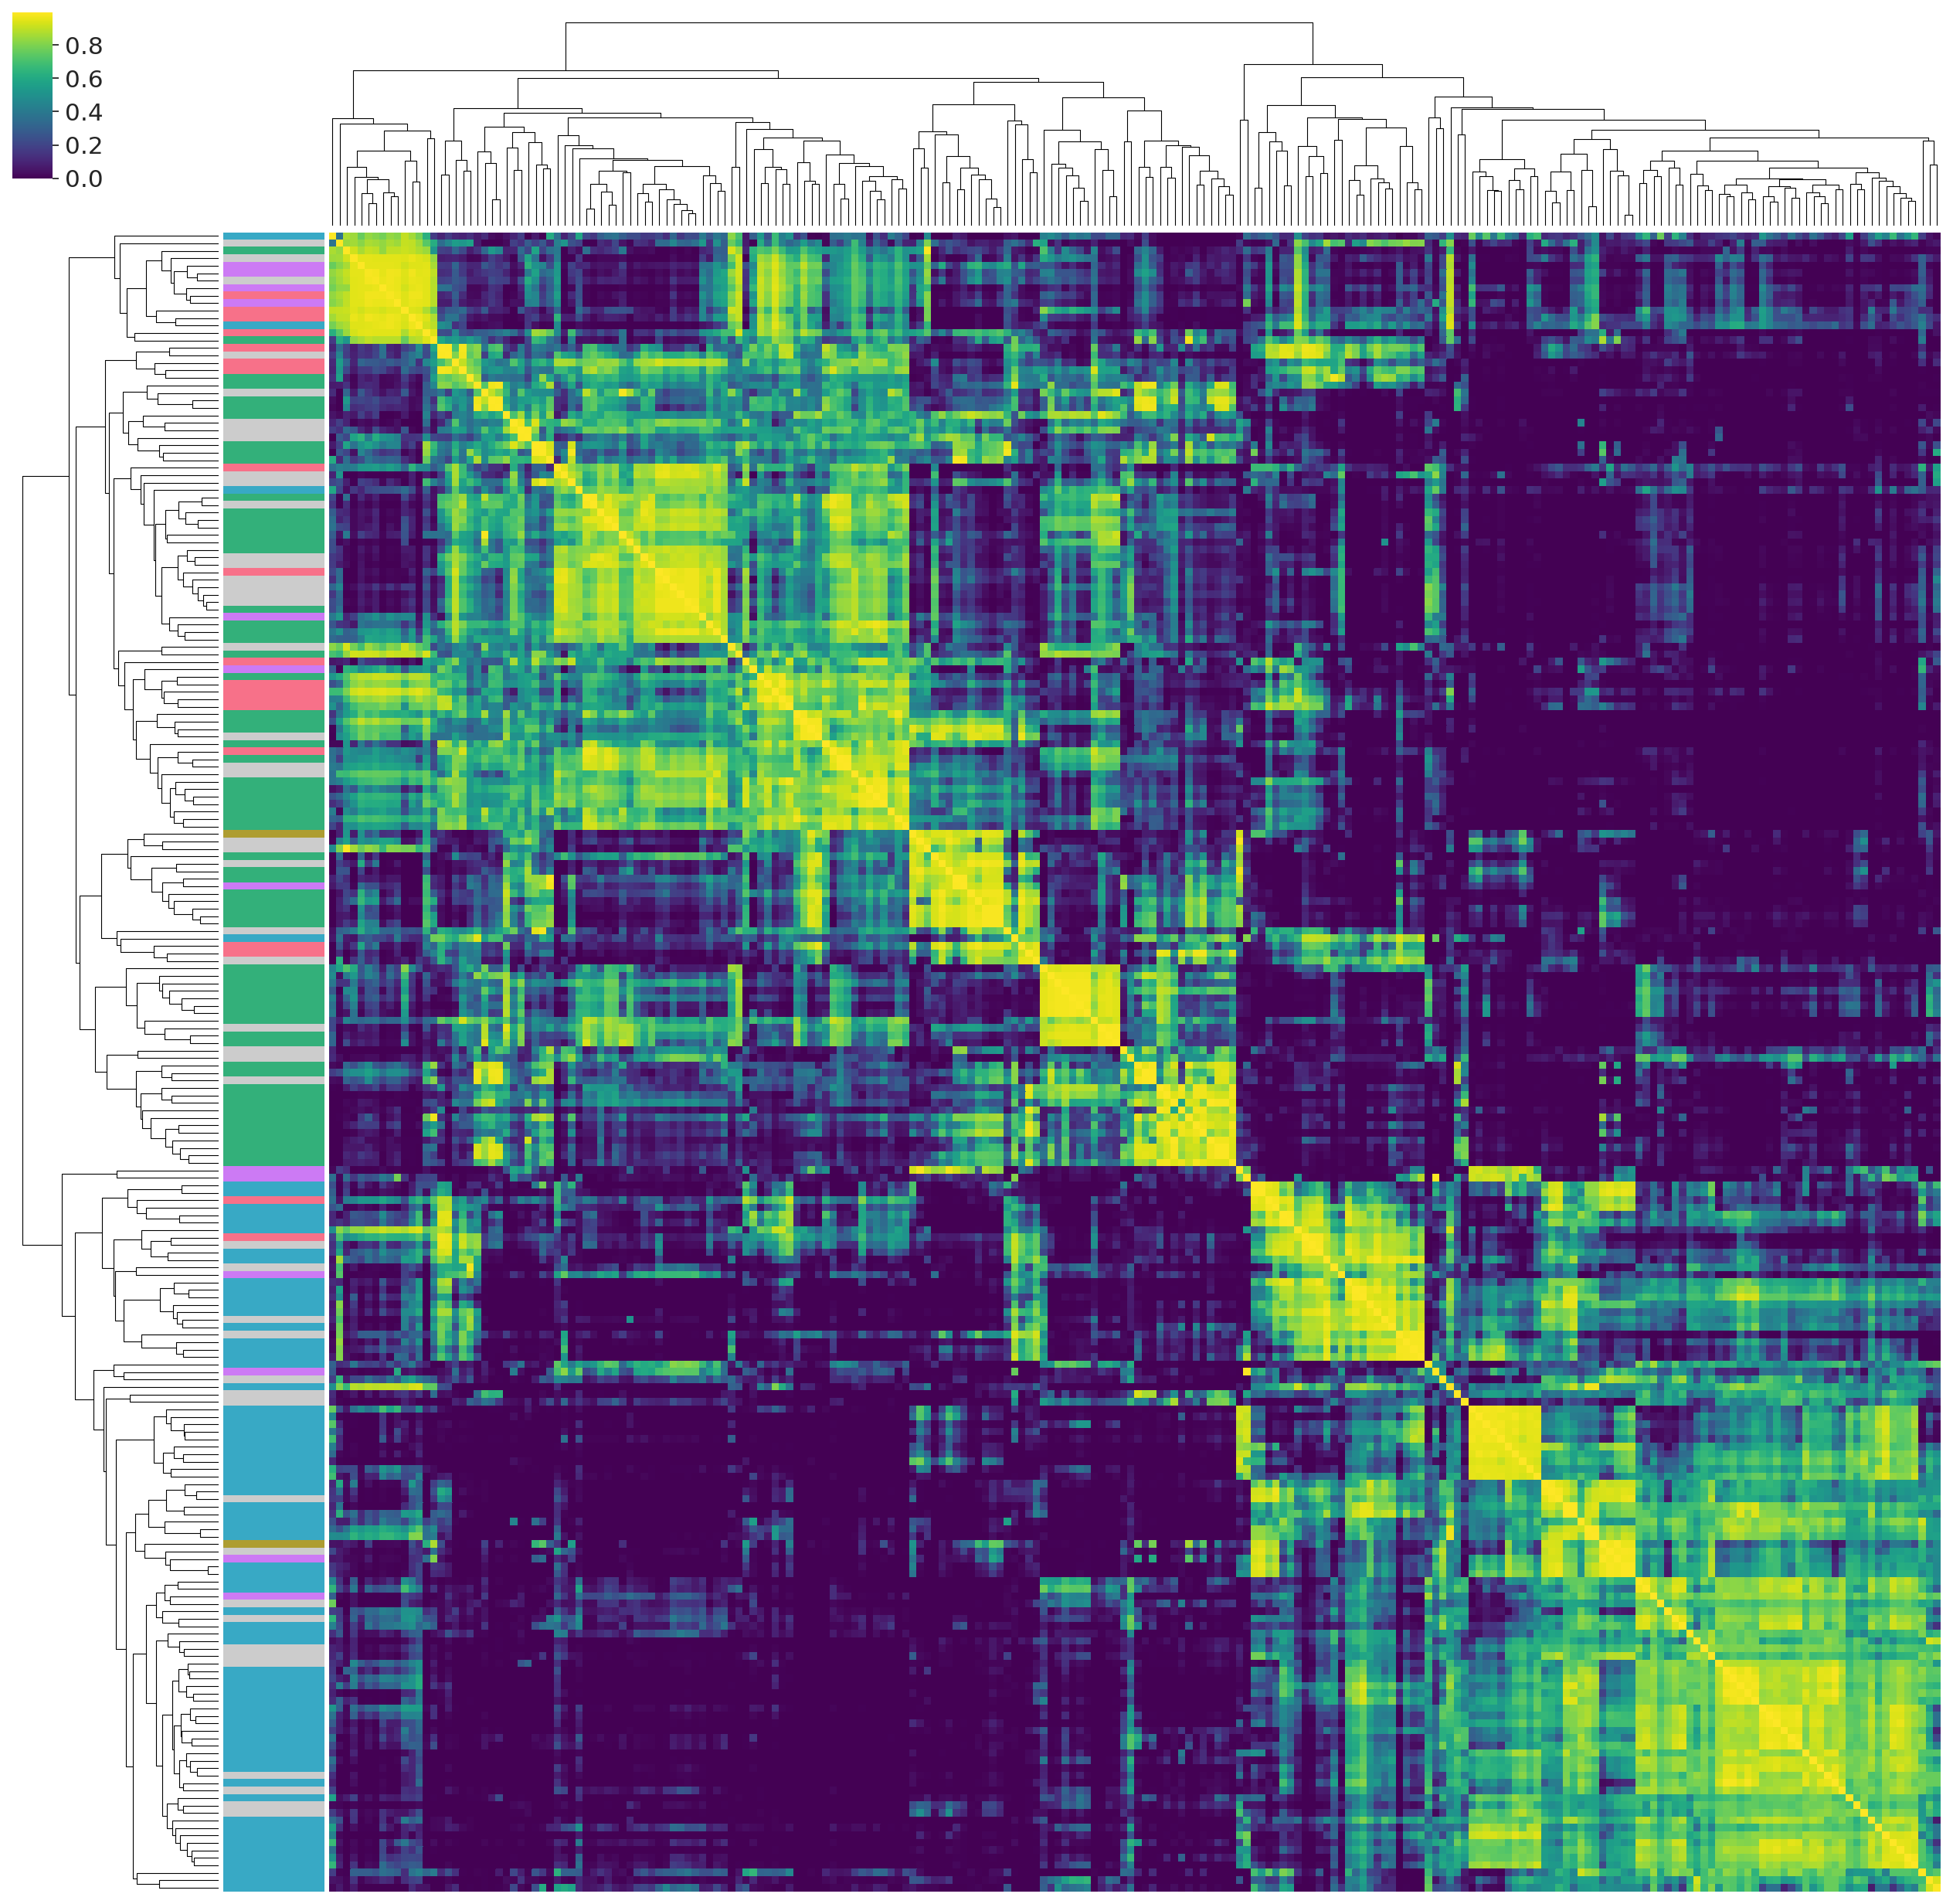

In [26]:
droplet1.plot_csi(cluster_n=5, cluster=drop_clust, lut=reg_clust_lut)

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


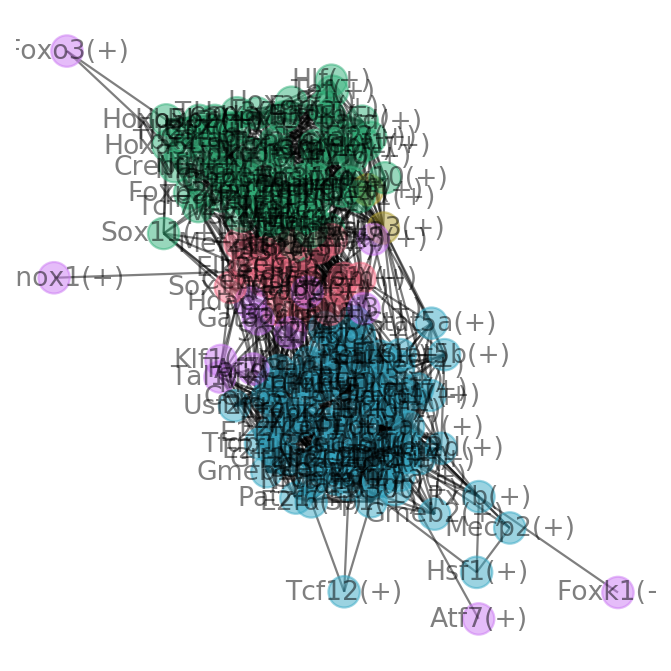

In [110]:
pseudo.regulon_network(0.70,save = 'data/integrated_regulon_regulon_network.gexf', lut = reg_clust_lut)


In [114]:
pseudo.links_filtered_reg.to_csv('data/regulon_network_links.tsv', sep = '\t')

### Regulon compositional similarities between atlases

In [16]:
drop_table =info_table(regulons_drop)
facs_table = info_table(regulons_facs)
mca_table = info_table(regulons_mca)

In [18]:
def intersection(s1, s2) : 
  
    # Find the intersection of the two sets  
    intersect = s1 & s2 ; 
  
    return intersect;  

# Function to return the Jaccard index of two sets  
def jaccard_index(s1, s2) : 
      
    # Sizes of both the sets  
    size_s1 = len(s1);  
    size_s2 = len(s2);  
  
    # Get the intersection set  
    intersect = intersection(s1, s2);  
  
    # Size of the intersection set  
    size_in = len(intersect);  
  
    # Calculate the Jaccard index  
    # using the formula  
    jaccard_in = size_in  / (size_s1 + size_s2 - size_in);  
  
    # Return the Jaccard index  
    return jaccard_in


def calc_jaccard(reg1, reg2):
    di = {}
    for i in list(set(reg1.Regulon) & set(reg2.Regulon)):
        di[i] = jaccard_index(set(reg1.loc[i].genes), set(reg2.loc[i].genes))
    return di  

In [19]:
facs_jc = pd.DataFrame(calc_jaccard(drop_table, facs_table), index = ['TM - SS2']).T

In [20]:
mca_jc = pd.DataFrame(calc_jaccard(drop_table, mca_table), index = ['MCA']).T

In [25]:
merge = pd.concat([facs_jc, mca_jc], axis = 1).reset_index()

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [37]:
spear_corr = merge.corr(method = 'spearman').iloc[1,0]
pears_corr = merge.corr().iloc[1,0]

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


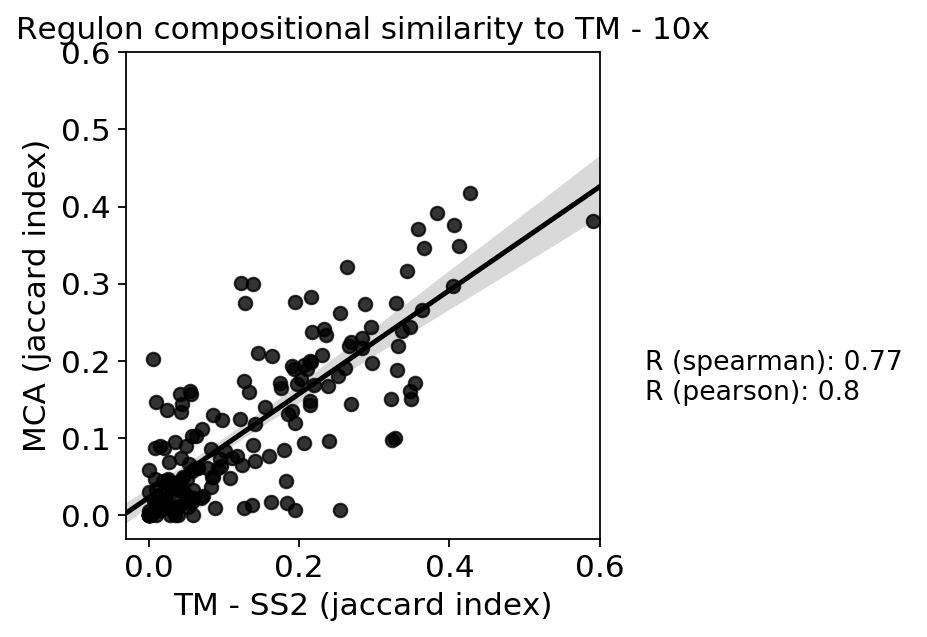

In [44]:
plt.figure(figsize = (8,4))
sns.regplot('TM - SS2', 'MCA',data = merge.dropna(), color = 'k')
plt.grid(False)
plt.title('Regulon compositional similarity to TM - 10x')
plt.ylabel('MCA (jaccard index)')
plt.xlabel('TM - SS2 (jaccard index)')

plt.ylim(-0.03, 0.6)
plt.xlim(-0.03, 0.6)
plt.subplots_adjust(right=0.55)
left, right = plt.xlim() 
plt.text(right * 1.1, 0.15,'R (spearman): {} \nR (pearson): {}'.format(round(spear_corr, 2), round(pears_corr, 2)), fontsize=12)
    
plt.savefig('figures/facs_mca_jaccard_scatter.pdf')

## Single cell resolution

In [15]:
from RegulonPreprocessing import preprocess_single_cell

In [16]:
## Loading preprocesssed Anndata objetcs (due to the time regression and scaling takes)
droplet = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/TM/droplet_scanpy_scaled.h5ad')
facs = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/TM/facs_scanpy_scaled.h5ad')
mca = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/MCA/mca_scanpy_scaled.h5ad')

In [17]:
droplet.obs['Super'] = droplet.obs.celltype.map(mapper)
facs.obs['Super'] = facs.obs.celltype.map(mapper)
mca.obs['Super'] = mca.obs.celltype.map(mapper)

### calculate regulon AUC

In [18]:
ex_matrix = droplet.X
ex_matrix = pd.DataFrame(data= ex_matrix,
                              index=pd.DataFrame(droplet.obs.index.values),
                              columns=droplet.var.index.values)
        

droplet_auc_mtx = aucell(ex_matrix, regulons_drop, num_workers=24)


ex_matrix = facs.X
ex_matrix = pd.DataFrame(data= ex_matrix,
                              index=pd.DataFrame(facs.obs.index.values),
                              columns=facs.var.index.values)
        

facs_auc_mtx = aucell(ex_matrix, regulons_facs, num_workers=24)



ex_matrix = mca.X
ex_matrix = pd.DataFrame(data= ex_matrix,
                              index=pd.DataFrame(mca.obs.index.values),
                              columns=mca.var.index.values)
        

mca_auc_mtx = aucell(ex_matrix, regulons_mca, num_workers=24)

### Merge scanpy objects

In [20]:
merged = sc.AnnData.concatenate(droplet, facs, mca , join='inner')
merged.obs['celltype'] = pd.Categorical(merged.obs['celltype'])
merged.obs['protocol'] = pd.Categorical(merged.obs['protocol'])
merged.obs['tissue'] = pd.Categorical(merged.obs['tissue'])

In [22]:
merged_auc_mtx = pd.concat([droplet_auc_mtx, facs_auc_mtx, mca_auc_mtx], join='inner', axis=0)

### make regulon analysis object

In [23]:
merged_all = RegulonsAnalysis( regulons_mca,  merged, merged_auc_mtx)

### Embed integrated dataset on RAS

/gpfs/gss1/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/Final_notebooks/5_Regulon_analysis/RegulonAnalysis.py:471: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if 'X_pca' in  self.regulon_scanpy.obsm:


PCA not computed - using 10 principal components


... storing 'original_annotation' as categorical


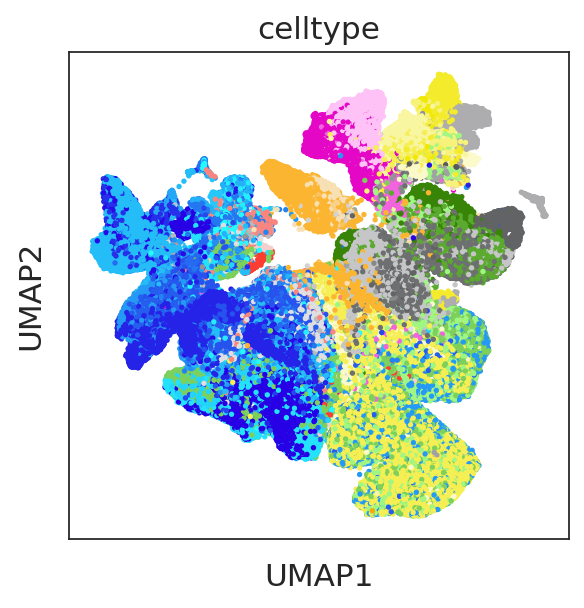

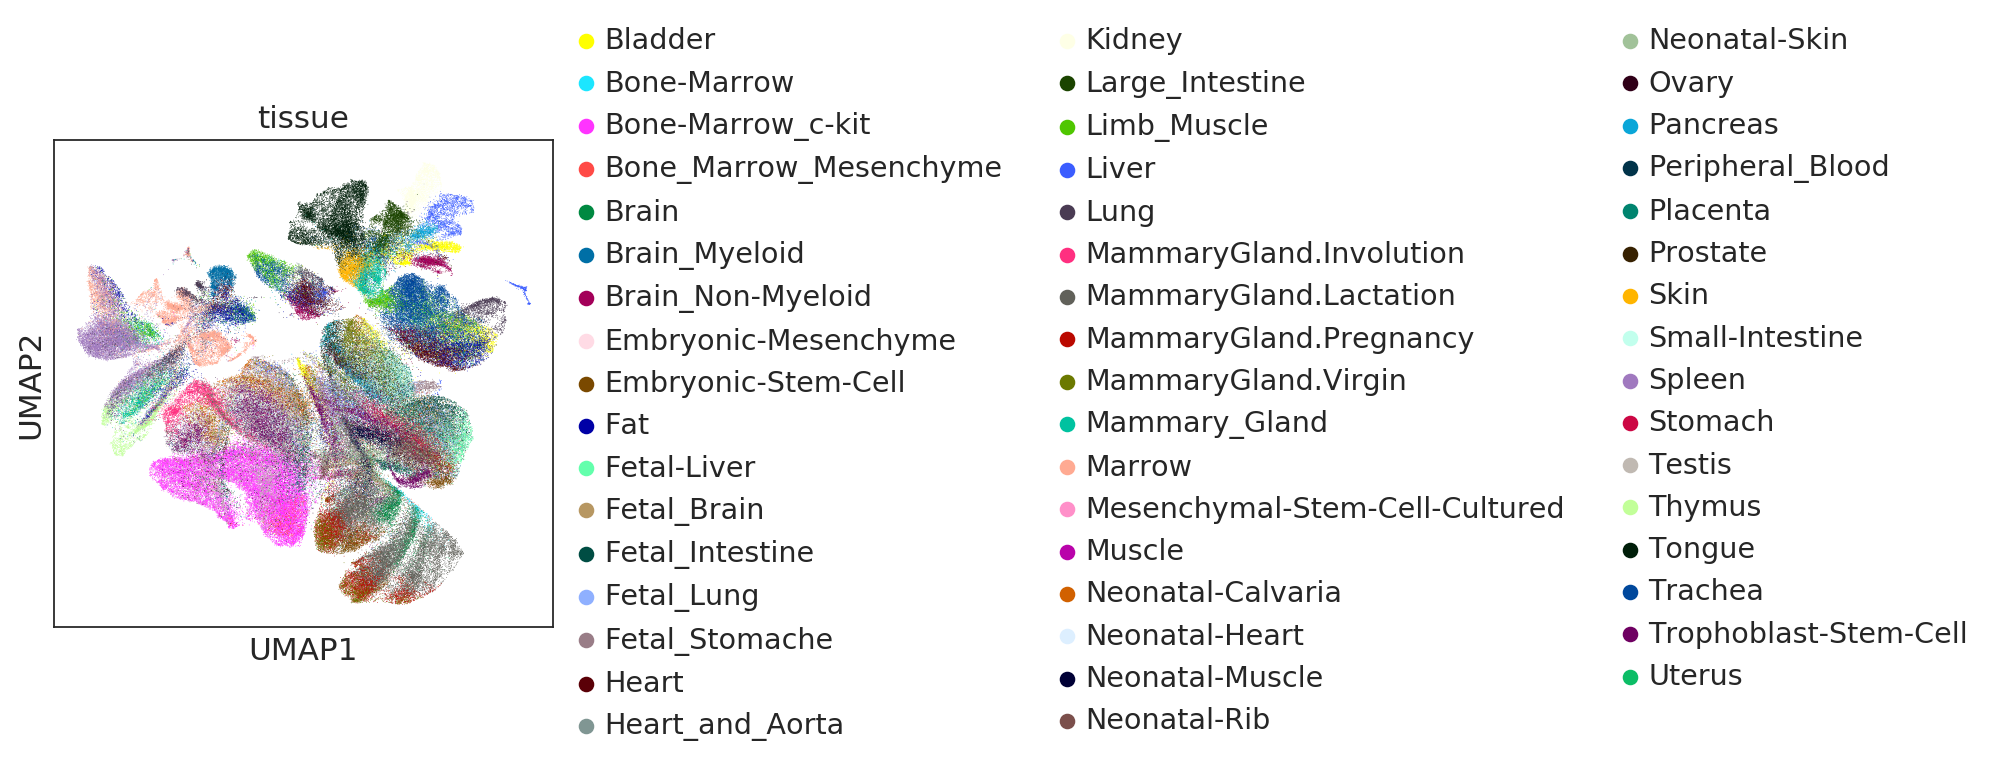

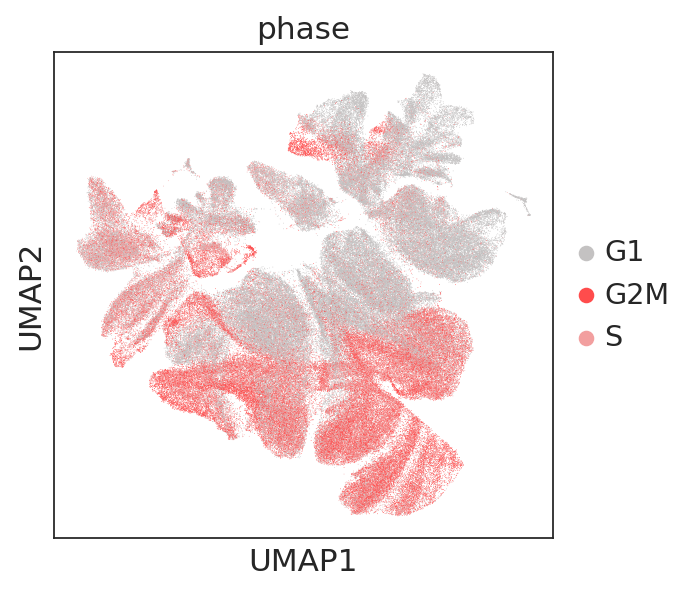

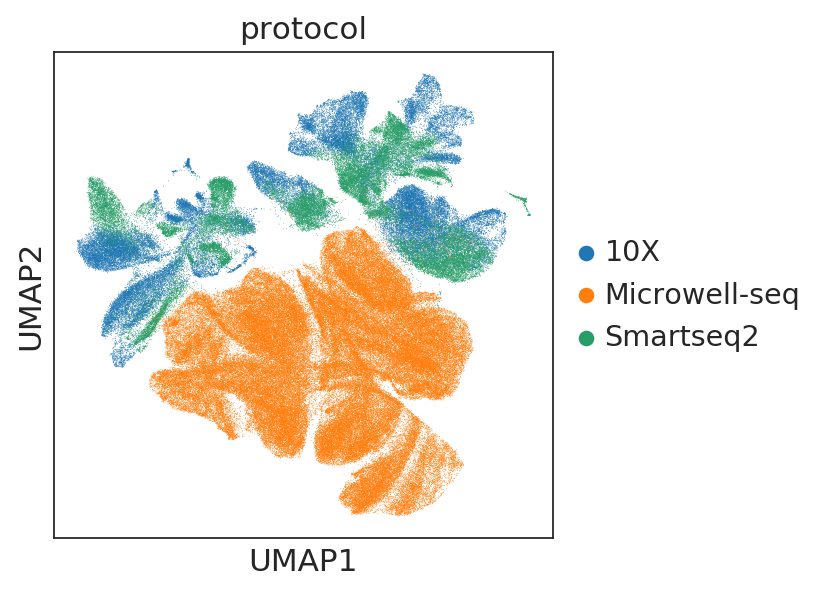

In [24]:


merged_all.plot('umap', 'celltype', color_index=colormap, pcs= 10, color_index_type='color_grad', point_size = 2)
merged_all.plot('umap', 'tissue', color_index=colormap, pcs= 10, color_index_type='color_grad')
merged_all.plot('umap', 'cellcycle', color_index=colormap, pcs= 10, color_index_type='color_grad')
merged_all.plot('umap', 'protocol', color_index=colormap, pcs= 10, color_index_type='color_grad')

## Single cell and Pseudobulk comparison

In [26]:
# Get mean and standard deviation of RAS for PB and SC
all_df = pd.DataFrame({'PB_mean':pd.melt(pseudo.auc_mtx).groupby('Regulon').mean()['value'].tolist(),
                       'SC_mean':pd.melt(merged_all.auc_mtx).groupby('variable').mean()['value'].tolist(),
                       'SC_sd':pd.melt(merged_all.auc_mtx).groupby('variable').std()['value'].tolist(),
                      'PB_sd':pd.melt(pseudo.auc_mtx).groupby('Regulon').std()['value'].tolist()},
            index =pseudo.auc_mtx.columns.tolist()  )

### SC vs. PB mean RAS scatterplot over all celltypes

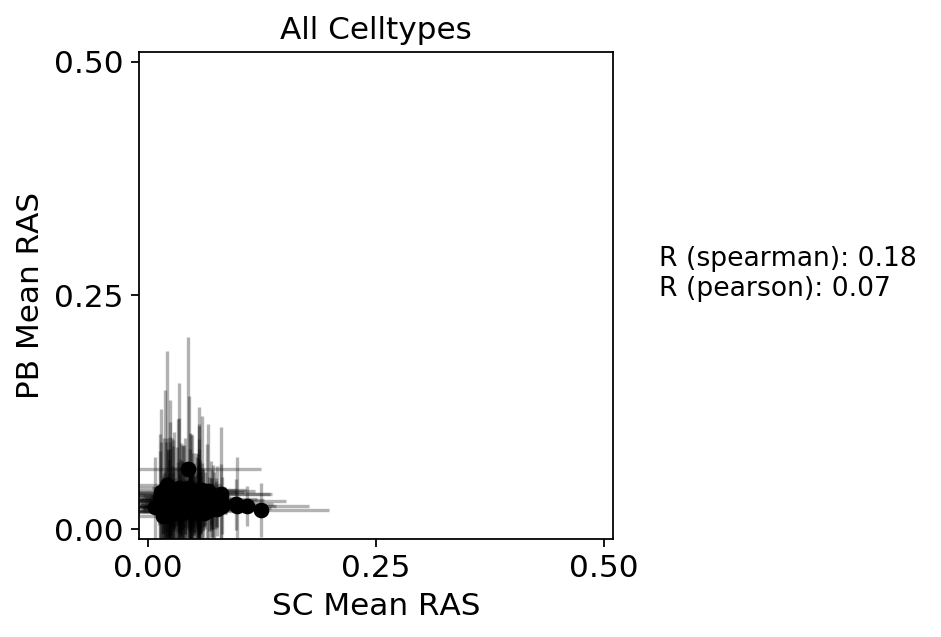

In [30]:
plt.figure(figsize = (8,4))
plt.errorbar(x = all_df.SC_mean, y = all_df.PB_mean, yerr=all_df.PB_sd, xerr = all_df.SC_sd, fmt='o', c = 'k', alpha = 0.3)
plt.scatter(x = all_df.SC_mean, y = all_df.PB_mean, c = 'k')
plt.title('All Celltypes')
plt.xlabel('SC Mean RAS')
plt.ylabel('PB Mean RAS')
plt.grid(False)
spear_corr = all_df.corr(method = 'spearman').iloc[1,0]
pears_corr = all_df.corr().iloc[1,0]
    
plt.ylim(-0.01,0.51)
plt.xlim(-0.01,0.51)
plt.xticks([0, 0.25, 0.5])
plt.yticks([0, 0.25, 0.5])


plt.subplots_adjust(right=0.55)
left, right = plt.xlim() 
plt.text(right * 1.1, 0.25,'R (spearman): {} \nR (pearson): {}'.format(round(spear_corr, 2), round(pears_corr, 2)), fontsize=12)
    
plt.savefig('figures/Integrated_Regulon_PB_RAS_vs_SC_RAS_All_celltypes.pdf')

In [91]:
#Map cell type to cell group
mapper = {x:y for x,y in zip(colormap.celltype, colormap.Super_type)}
pseudo.regulon_scanpy.obs['Super'] = pseudo.regulon_scanpy.obs.celltype.map(mapper)
merged_all.regulon_scanpy.obs['Super'] = merged_all.regulon_scanpy.obs.celltype.map(mapper)

In [31]:
#Function to plot Mean RAS scatterplot for a cell group
def plot_mean_RAS_scatter(cell_group):

    sub = pseudo.regulon_scanpy[pseudo.regulon_scanpy.obs.Super == cell_group]
    all_sub = merged_all.regulon_scanpy[merged_all.regulon_scanpy.obs.Super == cell_group]
    
    
    all_df = pd.DataFrame({'PB_mean':pd.melt(pseudo.auc_mtx.loc[[x for x in sub.obs_names.tolist()],:]).groupby('Regulon').mean()['value'].tolist(),
                       'SC_mean':pd.melt(merged_all.auc_mtx.loc[[x for x in all_sub.obs_names.tolist()],:]).groupby('variable').mean()['value'].tolist(),
                       'SC_sd':pd.melt(merged_all.auc_mtx.loc[[x for x in all_sub.obs_names.tolist()],:]).groupby('variable').std()['value'].tolist(),
                      'PB_sd':pd.melt(pseudo.auc_mtx.loc[[x for x in sub.obs_names.tolist()],:]).groupby('Regulon').std()['value'].tolist()},
            index =pseudo.auc_mtx.columns.tolist()  )
    spear_corr = all_df.corr(method = 'spearman').iloc[1,0]
    pears_corr = all_df.corr().iloc[1,0]
    
    plt.figure(figsize = (8,4))
    
    
    plt.errorbar(x = all_df.SC_mean, y = all_df.PB_mean, yerr=all_df.PB_sd, xerr = all_df.SC_sd, fmt='o', c = 'k', alpha = .3)
    plt.scatter(x = all_df.SC_mean, y = all_df.PB_mean, c = 'k')
    
    
    plt.title(cell_group)
    plt.grid(False)
    plt.xlabel('SC Mean RAS')
    plt.ylabel('PB Mean RAS')
    
    plt.ylim(-0.01,0.51)
    plt.xlim(-0.01,0.51)
    plt.xticks([0, 0.25, 0.5])
    plt.yticks([0, 0.25, 0.5])

    plt.subplots_adjust(right=0.55)
    
    left, right = plt.xlim() 
    plt.text(right * 1.1, 0.25, 'R (spearman): {} \nR (pearson): {}'.format(round(spear_corr, 2), round(pears_corr, 2)), fontsize=12)
    
    plt.savefig('figures/Integrated_Regulon_PB_RAS_vs_SC_RAS_{}.pdf'.format(cell_group))
    plt.close()


In [32]:
for i in list(set(pseudo.regulon_scanpy.obs['Super'])):
    plot_mean_RAS_scatter(i)

## RAS equality between PB and SC (by Gini coefficient)

In [94]:
#Function to calculate the gini coefficient of an array
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [97]:
def plot_gini(sub_by = None, colors = None):
    if sub_by is None:
        title = 'All Celltypes'
        gini_pb = pseudo.auc_mtx.apply(lambda x: gini(x.values))
        gini_sc = merged_all.auc_mtx.apply(lambda x: gini(x.values))
    else: 
        title = sub_by
        sub = pseudo.regulon_scanpy[pseudo.regulon_scanpy.obs.Super == sub_by]
        all_sub = merged_all.regulon_scanpy[merged_all.regulon_scanpy.obs.Super == sub_by]
        
        
        gini_pb = pseudo.auc_mtx.loc[[x for x in sub.obs_names.tolist()],:].apply(lambda x: gini(x.values))
        gini_sc = merged_all.auc_mtx.loc[[x for x in all_sub.obs_names.tolist()],:].apply(lambda x: gini(x.values))
    
    gini_df = pd.melt(pd.DataFrame({'PB':gini_pb,
             'SC':gini_sc}).reset_index(), id_vars=['Regulon'])
    
    
    sns.violinplot(y = 'value', x = 'variable', data = gini_df, cut = 0, zorder=10, color = 'w')
    sns.stripplot(y = 'value', x = 'variable', data = gini_df, palette=colors)
    plt.xlabel('')
    plt.ylabel('Gini coefficient')
    plt.title(title)
    plt.savefig('figures/integrated_Gini_co_RAS_{}.pdf'.format(title))

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


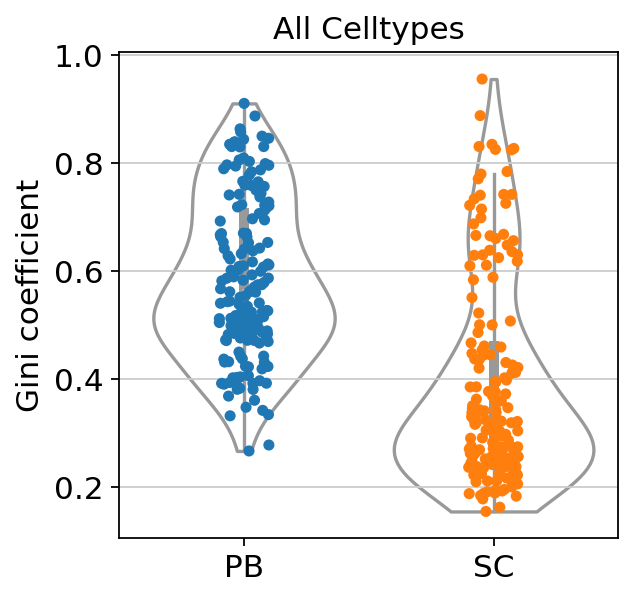

In [98]:
#Plot the Gini coefficient for all celltypes
plot_gini()

In [99]:
col = {'endothelial cell':['#f7ba1e', '#f7991e'],
 'immune':['#33bbf5','#3350f5'],
 'basal cell':['#c11ef7','#831ef7'],
 'blood cell':['#ff634f','#f7371e'],
 'stem cell':['#72e368', '#10ad02'],
 'specialized':['#c4c4c4','#858585'],
 'epithelial cell':['#eaed82', '#dbe03d']}

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


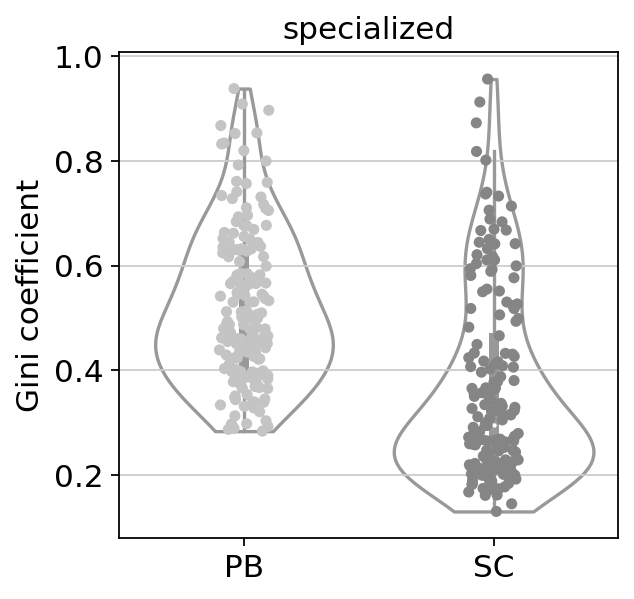

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


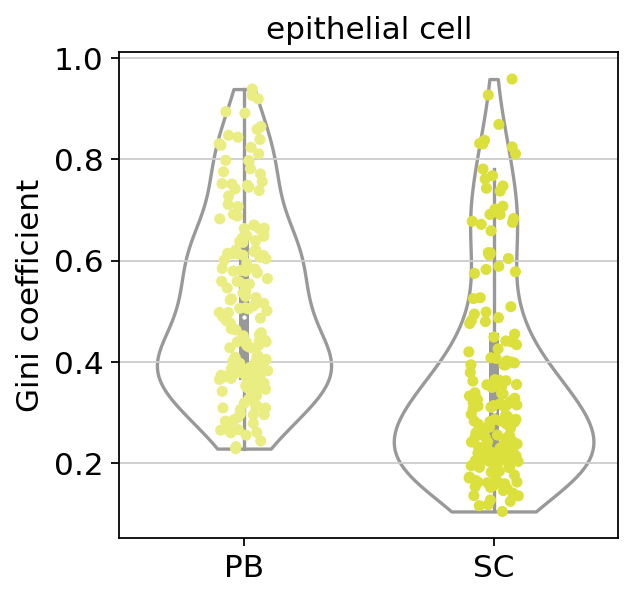

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


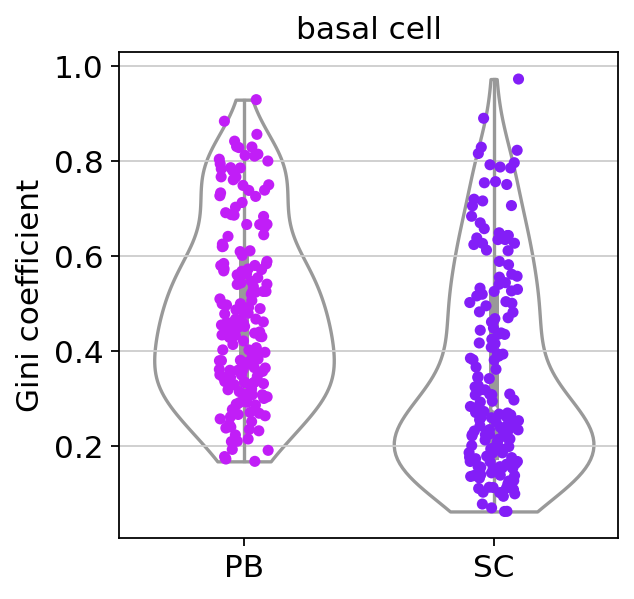

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


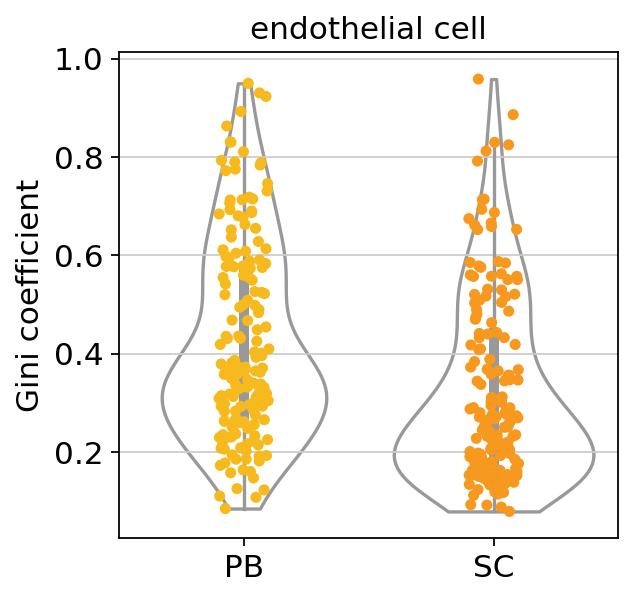

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


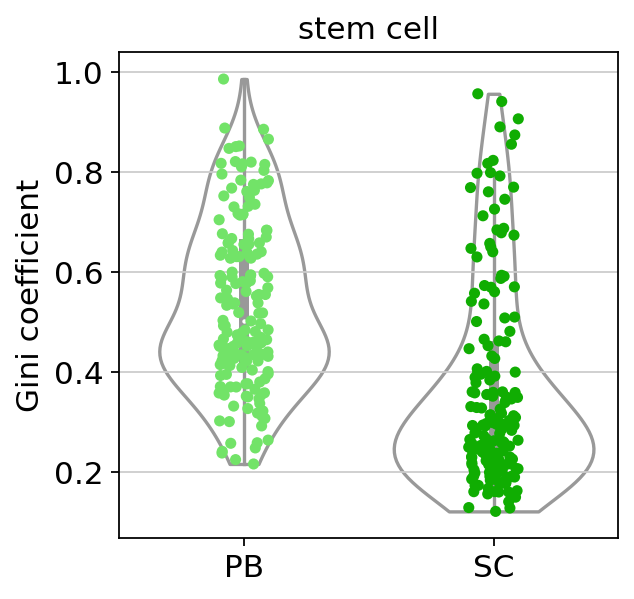

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


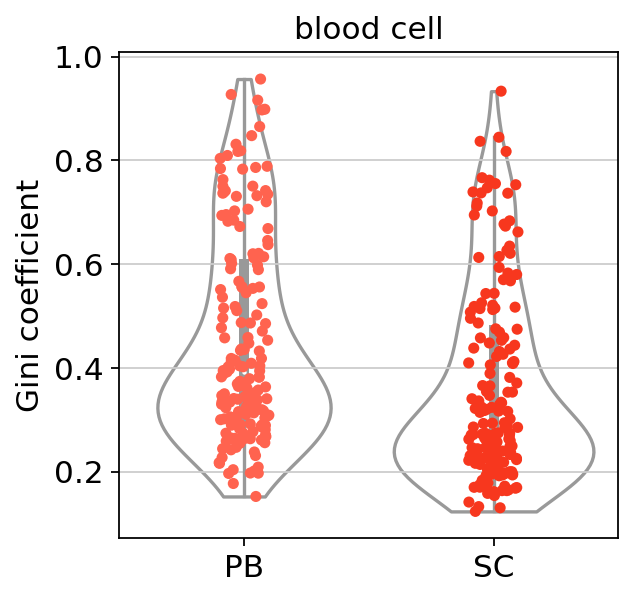

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


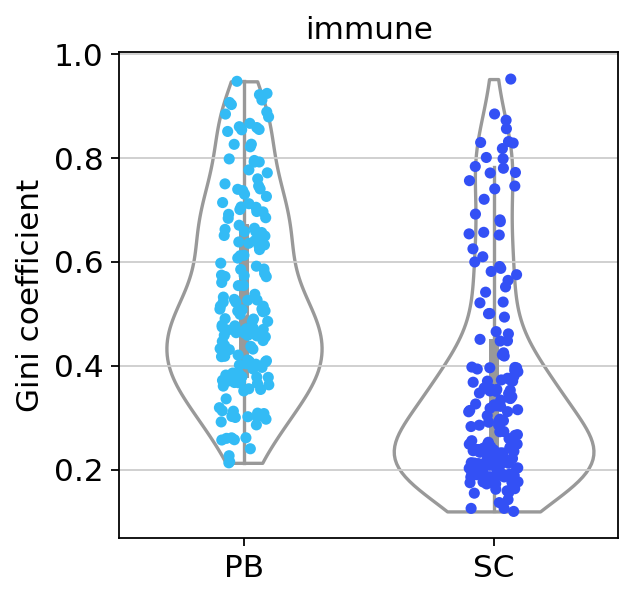

In [100]:
# Plot the gini coefficient for all cell groups individually
for i in list(set(pseudo.regulon_scanpy.obs['Super'])):
    plot_gini(i, colors = col[i] )
    plt.show()